In [6]:
import pandas as pd
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split

# Function to recommend dive spots for a specific user
def recommend_dive_spots(user_id, svd_model, user_ratings_df, dive_sites_df, top_n=5):
    # Get all dive site IDs
    all_dive_sites = dive_sites_df["id"].unique()
    
    # Filter out dive sites the user has already rated
    rated_sites = user_ratings_df[user_ratings_df["user_id"] == user_id]["dive_site_id"].values
    unrated_sites = [site for site in all_dive_sites if site not in rated_sites]
    
    # Predict ratings for unrated dive sites
    predictions = []
    for dive_site_id in unrated_sites:
        pred = svd_model.predict(user_id, dive_site_id).est
        predictions.append((dive_site_id, pred))
    
    # Sort dive sites by predicted ratings in descending order
    predictions.sort(key=lambda x: x[1], reverse=True)
    
    # Get the top N recommended dive sites
    top_dive_sites = predictions[:top_n]
    top_dive_site_ids = [site for site, _ in top_dive_sites]
    
    # Fetch details of the recommended dive sites
    recommended_sites = dive_sites_df[dive_sites_df["id"].isin(top_dive_site_ids)]
    return recommended_sites, top_dive_sites


In [ ]:
# Load user ratings data and dive sites data
user_ratings_df = pd.read_csv("../user_ratings_data.csv")  # Replace with your data file
dive_sites_df = pd.read_csv('../dive_sites.csv')
features = pd.read_csv('../preferences.csv')

# Prepare data for surprise
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(user_ratings_df[["user_id", "dive_site_id", "rating"]], reader)
trainset, _ = train_test_split(data, test_size=0.3, random_state=42)

# Train the SVD model
svd_model = SVD(n_factors=25, n_epochs=10, biased=True)
svd_model.fit(trainset)

# Input user ID and recommend dive spots
user_id = int(input("Enter User ID: "))
recommended_sites, top_dive_sites = recommend_dive_spots(user_id, svd_model, user_ratings_df, dive_sites_df, top_n=5)
print(f'Features for user {user_id}')
print(features[features['user_id']==user_id])
print(r' ')
# Display the recommendations
if recommended_sites.empty:
    print(f"No recommendations available for User {user_id}.")
else:
    print(f"\nRecommended Dive Spots for User {user_id}:")
    print(recommended_sites[["id", "title","name", "region", "cluster","animal_id"]])
    print(top_dive_sites)

Features for user 11
    Unnamed: 0  user_id             preferred_regions preferred_animals  \
10          10       11  ['Puerto Rico', 'Sri Lanka']         [66, 413]   

              preferred_types preferred_clusters  
10  ['Ocean', 'Pool', 'Reef']             [2, 4]  
 

Recommended Dive Spots for User 11:
        id                         title  \
852    826                  Wailea South   
1025   995  Hausbucht Strandbad (Basis2)   
2265  2258                  Rubiah Utara   
2461  2454                        Aqua92   
3385  3377               Oro Verde (Bow)   

                                       name          region  cluster  \
852                                ['Reef']   United States        1   
1025                      ['Beach', 'Lake']         Austria        4   
2265  ['Drift', 'Reef', 'Channel', 'Ocean']       Indonesia        1   
2461                               ['Pool']          France        2   
3385                     ['Wreck', 'Ocean']  Cayman Islands   

In [55]:
def recommend_regions_with_rwev(user_id, svd_model, user_ratings_df, dive_sites_df, top_n=3, p=2, lambda_=4):
    # Get all dive site IDs and regions
    all_dive_sites = dive_sites_df[["id", "region"]].drop_duplicates()
    
    # Filter out dive sites the user has already rated
    rated_sites = user_ratings_df[user_ratings_df["user_id"] == user_id]["dive_site_id"].values
    unrated_sites = all_dive_sites[~all_dive_sites["id"].isin(rated_sites)]
    
    # Predict ratings for unrated dive sites
    predictions = []
    for _, row in unrated_sites.iterrows():
        dive_site_id = row["id"]
        region = row["region"]
        pred = svd_model.predict(user_id, dive_site_id).est
        predictions.append((region, dive_site_id, pred))
    
    # Convert predictions to DataFrame
    predictions_df = pd.DataFrame(predictions, columns=["region", "dive_site_id", "predicted_rating"])
    
    # Group by region and calculate RWEV
    def calculate_rwev(group):
        N = len(group)
        if N == 0:
            return 0
        weighted_sum = (group["predicted_rating"] ** p).sum()
        regularization = lambda_ / N
        return (weighted_sum / N) - regularization
    
    rwev_scores = predictions_df.groupby("region").apply(calculate_rwev).reset_index(name="rwev")
    
    # Sort regions by RWEV in descending order
    rwev_scores = rwev_scores.sort_values(by="rwev", ascending=False)
    
    # Get the top N regions
    top_regions = rwev_scores.head(top_n)
    
    # Fetch details of the top regions and their top dive sites
    region_recommendations = []
    for region in top_regions["region"]:
        top_sites_in_region = predictions_df[predictions_df["region"] == region] \
                              .sort_values(by="predicted_rating", ascending=False) \
                              .head(3)  # Top 3 sites per region
        region_recommendations.append({
            "region": region,
            "top_sites": dive_sites_df[dive_sites_df["id"].isin(top_sites_in_region["dive_site_id"])]
        })
    
    return region_recommendations



# Example usage
user_id = int(input("Enter User ID: "))
region_recommendations = recommend_regions_with_rwev(user_id, svd_model, user_ratings_df, dive_sites_df, top_n=10)

# Display recommendations
for rec in region_recommendations:
    print(f"\nRegion: {rec['region']}")
    print("Top Dive Sites:")
    print(rec["top_sites"][["id", "title", "name", "cluster", "animal_id"]])



Region: Saba
Top Dive Sites:
        id               title      name  cluster animal_id
1851  1851     Third Encounter  ['Reef']        0       NaN
1853  1853        Outer Limits  ['Reef']        0       NaN
1855  1855  Hole in the Corner  ['Reef']        0       NaN

Region: Curacao
Top Dive Sites:
        id                      title                                name  \
2301  2294            Barracuda Point  ['Drift', 'Reef', 'Wall', 'Ocean']   
2411  2405                Playa Lagun                            ['Reef']   
2416  2410  Scooter or Dwains Release           ['Drift', 'Reef', 'Wall']   

      cluster                                          animal_id  
2301        1  [77, 105, 104, 43, 44, 53, 61, 10, 17, 23, 317...  
2411        0                          [8, 1, 10, 18, 20, 6, 40]  
2416        3                                                NaN  

Region: Hawaii
Top Dive Sites:
        id                  title                                name  \
702    675     

## Further Tests

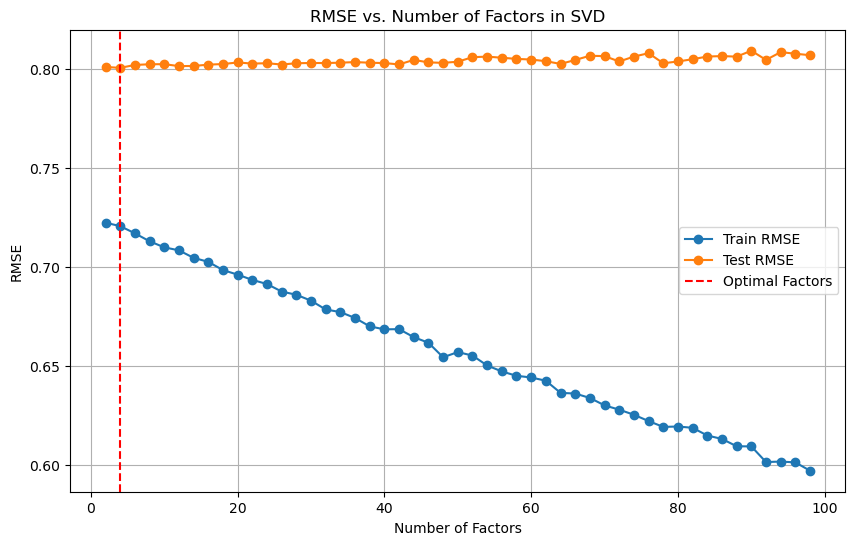

Optimal number of factors: 4


In [5]:
import matplotlib.pyplot as plt
from surprise import SVD
from surprise.model_selection import train_test_split
from surprise.accuracy import rmse

# Range of factors to test
n_factors_range = range(2, 100, 2)  # Test factors from 2 to 50 in steps of 2

# Store results
train_rmse = []
test_rmse = []

# Prepare train and test sets
trainset, testset = train_test_split(data, test_size=0.3, random_state=2)

# Loop through different numbers of factors
for n_factors in n_factors_range:
    # Build and train the SVD model
    svd = SVD(n_factors=n_factors, , n_epochs=20, biased=True)
    svd.fit(trainset)
    
    # Evaluate on the train set
    train_predictions = svd.test(trainset.build_testset())
    train_rmse.append(rmse(train_predictions, verbose=False))
    
    # Evaluate on the test set
    test_predictions = svd.test(testset)
    test_rmse.append(rmse(test_predictions, verbose=False))

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(n_factors_range, train_rmse, label='Train RMSE', marker='o')
plt.plot(n_factors_range, test_rmse, label='Test RMSE', marker='o')
plt.axvline(x=n_factors_range[test_rmse.index(min(test_rmse))], color='r', linestyle='--', label='Optimal Factors')
plt.title('RMSE vs. Number of Factors in SVD')
plt.xlabel('Number of Factors')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()

# Print optimal number of factors
optimal_factors = n_factors_range[test_rmse.index(min(test_rmse))]
print(f"Optimal number of factors: {optimal_factors}")


In [ ]:
import pandas as pd
import numpy as np
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from sklearn.metrics.pairwise import euclidean_distances

# Load user ratings and dive site data
user_ratings_df = pd.read_csv("user_ratings_data.csv")
dive_sites_df = pd.read_csv('dive_sites.csv')
features = pd.read_csv('preferences.csv')

# Function to calculate adjusted predictions
def adjusted_predictions(user_id, svd_model, user_ratings_df, dive_sites_df, distance_matrix, id_to_index, top_n=5):
    # Get all dive site IDs
    all_dive_sites = dive_sites_df["id"].unique()

    # Filter out dive sites the user has already rated
    rated_sites = user_ratings_df[user_ratings_df["user_id"] == user_id]["dive_site_id"].values
    unrated_sites = [site for site in all_dive_sites if site not in rated_sites]

    # Predict ratings for unrated dive sites
    user_factors = svd_model.pu[user_id]  # User latent factors
    predictions = []
    for dive_site_id in unrated_sites:
        # Get internal index of the dive site
        if dive_site_id not in id_to_index:
            continue
        dive_site_index = id_to_index[dive_site_id]

        # Retrieve item factors and calculate SVD score
        item_factors = svd_model.qi[dive_site_index]  # Item latent factors
        svd_score = np.dot(user_factors, item_factors)  # SVD predicted score

        # Incorporate distance matrix
        distances = distance_matrix[dive_site_index]
        similarity_score = np.exp(-distances)  # Convert distance to similarity
        weighted_score = svd_score * similarity_score.sum()  # Combine SVD score with similarity

        predictions.append((dive_site_id, weighted_score))

    # Sort dive sites by the combined score in descending order
    predictions.sort(key=lambda x: x[1], reverse=True)

    # Get the top N recommended dive sites
    top_dive_sites = predictions[:top_n]
    top_dive_site_ids = [site for site, _ in top_dive_sites]

    # Fetch details of the recommended dive sites
    recommended_sites = dive_sites_df[dive_sites_df["id"].isin(top_dive_site_ids)]
    return recommended_sites, top_dive_sites

# Prepare user-dive ratings for surprise
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(user_ratings_df[["user_id", "dive_site_id", "rating"]], reader)
trainset, testset = train_test_split(data, test_size=0.3, random_state=42)

# Train SVD model
svd_model = SVD(n_factors=25, reg_all=0.001, n_epochs=10, biased=True)
svd_model.fit(trainset)

# Map dive site IDs to internal indices
id_to_index = {id_: i for i, id_ in enumerate(trainset.all_items())}

# Create a distance matrix for dive sites
geo_features = dive_sites_df[["lat", "long"]].fillna(0).to_numpy()
distance_matrix = euclidean_distances(geo_features, geo_features)

# Input user ID and recommend dive spots
user_id = int(input("Enter User ID: "))
recommended_sites, top_dive_sites = adjusted_predictions(
    user_id, svd_model, user_ratings_df, dive_sites_df, distance_matrix, id_to_index, top_n=5
)

# Display the recommendations
if recommended_sites.empty:
    print(f"No recommendations available for User {user_id}.")
else:
    print(f"\nRecommended Dive Spots for User {user_id}:")
    print(recommended_sites)
    print("\nAdjusted Ratings:")
    print(top_dive_sites)
    
print(features[features['user_id']==user_id])



In [ ]:
import pandas as pd
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split, cross_validate
from surprise.accuracy import rmse, mae

# Load user ratings data
user_ratings_df = pd.read_csv("user_ratings_data.csv")

# Prepare the data for surprise library
reader = Reader(rating_scale=(1, 5))  # Define the rating scale
data = Dataset.load_from_df(user_ratings_df[["user_id", "dive_site_id", "rating"]], reader)

# Split into train and test sets
trainset, testset = train_test_split(data, test_size=0.3, random_state=42)

# Build and train the SVD model
svd = SVD(n_factors=10, n_epochs=10, biased=True)
svd.fit(trainset)

# Test the model
predictions = svd.test(testset)

# Evaluate the model
print("Model Evaluation:")
print(f"RMSE: {rmse(predictions):.4f}")
print(f"MAE: {mae(predictions):.4f}")

# Cross-validation for more robust evaluation
print("\nCross-validation results:")
cross_val_results = cross_validate(svd, data, measures=["RMSE", "MAE"], cv=5, verbose=True)

# Display predictions for the test set
print("\nSample predictions:")
for pred in predictions[:5]:  # Show first 5 predictions
    print(f"User {pred.uid} rated Dive Site {pred.iid} with {pred.r_ui}. Predicted: {pred.est:.2f}")
